In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
import os
import kaggle
import random
import zipfile
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from breast_cancer_dataset import BreastCancerDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
# Define dataset paths
DATA_DIR = "BreastHistopathology"
KAGGLE_DATASET = "paultimothymooney/breast-histopathology-images"
ZIP_FILE = "breast-histopathology-images.zip"

def ensure_dataset():
    """Ensures dataset is downloaded and extracted properly."""
    # 1️⃣ Create directory if it doesn't exist
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
        print(f"📁 Created dataset directory: {DATA_DIR}")

    # 2️⃣ Check if dataset is already extracted
    num_images = len(glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True))
    if num_images > 0:
        print(f"✅ Dataset already available with {num_images} images.")
        return  # Skip download

    # 3️⃣ Download dataset from Kaggle if not present
    if not os.path.exists(ZIP_FILE):
        print("📥 Downloading dataset from Kaggle...")
        kaggle.api.dataset_download_files(KAGGLE_DATASET, path="./", unzip=False)
        print("✅ Download complete!")

    # 4️⃣ Extract dataset
    print("📂 Extracting dataset...")
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("✅ Extraction complete!")

    # 5️⃣ Verify extraction
    num_images = len(glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True))
    if num_images == 0:
        raise RuntimeError(f"❌ Extraction failed. No images found in {DATA_DIR}.")

    print(f"✅ Dataset ready with {num_images} images.")

# Ensure dataset is downloaded & extracted
ensure_dataset()

# ✅ Get all image paths
all_image_paths = glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True)
print(f"✅ Total images found: {len(all_image_paths)}")

# ✅ Filter non-cancerous images (class '0') for training
normal_paths = glob(os.path.join(DATA_DIR, "**", "0", "*.png"), recursive=True)  # Non-cancerous images
cancerous_paths = glob(os.path.join(DATA_DIR, "**", "1", "*.png"), recursive=True)  # Cancerous images

print(f"🔹 Non-cancerous images (for training): {len(normal_paths)}")
print(f"🔹 Cancerous images (for testing): {len(cancerous_paths)}")

# ✅ Now use `normal_paths` for training & validation, and `cancerous_paths` for testing

📁 Created dataset directory: BreastHistopathology
📥 Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
✅ Download complete!
📂 Extracting dataset...
✅ Extraction complete!
✅ Dataset ready with 555048 images.
✅ Total images found: 555048
🔹 Non-cancerous images (for training): 397476
🔹 Cancerous images (for testing): 157572


In [4]:
# Get all image paths
all_image_paths = glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True)
print(f"✅ Total images found: {len(all_image_paths)}")

# Split into Train (80%), Validation (10%), Test (10%)
train_paths, test_paths = train_test_split(normal_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(test_paths+cancerous_paths, test_size=0.3, random_state=42)

print(f"🔹 Train set: {len(train_paths)} images")
print(f"🔹 Validation set: {len(val_paths)} images")
print(f"🔹 Test set: {len(test_paths)} images")

# Define image preprocessing (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create PyTorch Datasets
train_dataset = BreastCancerDataset(train_paths, transform=transform)
val_dataset = BreastCancerDataset(val_paths, transform=transform)
test_dataset = BreastCancerDataset(test_paths, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("✅ DataLoaders ready!")

✅ Total images found: 555048
🔹 Train set: 317980 images
🔹 Validation set: 165947 images
🔹 Test set: 71121 images
✅ DataLoaders ready!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
# Define fraction to use for quick testing
fraction = 0.01  # Use only 1% of the dataset

# Reduce dataset size while maintaining the same split ratio
def reduce_dataset_size(image_paths, fraction):
    new_size = max(1, int(len(image_paths) * fraction))  # Ensure at least 1 image
    return random.sample(image_paths, new_size)

# Reduce train, val, and test sets
train_paths = reduce_dataset_size(train_paths, fraction)
val_paths = reduce_dataset_size(val_paths, fraction)
test_paths = reduce_dataset_size(test_paths, fraction)

print(f"🔹 New Train set: {len(train_paths)} images")
print(f"🔹 New Validation set: {len(val_paths)} images")
print(f"🔹 New Test set: {len(test_paths)} images")

# Create PyTorch Datasets with reduced data
train_dataset = BreastCancerDataset(train_paths, transform=transform)
val_dataset = BreastCancerDataset(val_paths, transform=transform)
test_dataset = BreastCancerDataset(test_paths, transform=transform)

# Create DataLoaders with reduced dataset
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=4)

print("✅ Reduced DataLoaders ready for quick testing!")

🔹 New Train set: 3179 images
🔹 New Validation set: 1659 images
🔹 New Test set: 711 images
✅ Reduced DataLoaders ready for quick testing!


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim=3*64*64, latent_dim=128, dropout_rate=0.3):
        super(FullyConnectedVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(dropout_rate)

        self.fc_mu = nn.Linear(512, latent_dim)   # Mean of latent space
        self.fc_logvar = nn.Linear(512, latent_dim)  # Log variance of latent space

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.drop3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.drop4 = nn.Dropout(dropout_rate)

        self.fc5 = nn.Linear(1024, input_dim)  # Output flattened image

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.02)
        x = self.drop1(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.02)
        x = self.drop2(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        z = F.leaky_relu(self.bn3(self.fc3(z)), negative_slope=0.02)
        z = self.drop3(z)
        z = F.leaky_relu(self.bn4(self.fc4(z)), negative_slope=0.02)
        z = self.drop4(z)
        z = torch.sigmoid(self.fc5(z))  # Output in [0,1] range
        return z.view(z.size(0), 3, 64, 64)  # Reshape back to image format

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Loss function
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x.view(x.size(0), -1), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.1 * kl_div

In [7]:
# Load a saved model checkpoint
def load_trained_vae(model_path, latent_dim=64, device='cpu'):
    model = FullyConnectedVAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

# Preliminary model evaluation based on sum total reconstruction loss
def evaluate_vae(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)

    total_recon_loss = 0
    num_samples = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            recon_images, _, _ = model(images)

            recon_loss = F.mse_loss(recon_images, images, reduction='sum')
            total_recon_loss += recon_loss.item()
            num_samples += images.size(0)

    avg_recon_loss = total_recon_loss / num_samples
    print(f"Average Reconstruction Loss: {avg_recon_loss:.4f}")

    return avg_recon_loss

# Visualize Images (Expectation vs. Reconstruction)
def visualize_reconstruction(model, dataloader, action, device='cpu', num_images=10):
    model.eval()
    model.to(device)

    images, _ = next(iter(dataloader))
    images = images.to(device)
    indices = torch.randperm(images.size(0))[:num_images]
    images = images[indices]

    with torch.no_grad():
        recon_images, _, _ = model(images)

    images = (images + 1) / 2
    recon_images = (recon_images + 1) / 2

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis("off")
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")

    plot_name = f"{action}_sample_results.png"
    plt.savefig(plot_name)
    plt.show()

In [8]:
# Train model
def train_vae(model, dataloader, num_epochs=100, device='cpu', save_path="vae_colab_64x64_64L.pth"):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses = []  # Store total loss
    recon_losses = []  # Store reconstruction loss
    kl_losses = []  # Store KL divergence loss

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0

        print(f"Epoch {epoch+1}/{num_epochs}:", end=" ")

        # Raw KL-div contribution to total loss
        kl_weight = 1.0
        # [Optional] KL Annealing: Linearly increase from 0.01 → 1.0 over training
        # kl_weight = min(1.0, 0.01 + (epoch / num_epochs))

        for images, _ in dataloader:
            print(".", end="")
            images = images.to(device)

            optimizer.zero_grad()
            recon_x, mu, logvar = model(images)

            # Compute Losses
            recon_loss = F.mse_loss(recon_x, images, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total loss is weighted sum of reconstruction loss and KL divergence
            loss = recon_loss + kl_weight * kl_div

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_div.item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon_loss = total_recon_loss / len(dataloader.dataset)
        avg_kl_loss = total_kl_loss / len(dataloader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)

        print(f" | Loss: {avg_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, KL weight: {kl_weight:.3f})")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), save_path)
            print(f"Model checkpoint saved at epoch {epoch+1}")

    # Save final model
    torch.save(model.state_dict(), save_path)
    print("Training complete! Model saved.")

    # Plot Training Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, num_epochs + 1), train_losses[1:], label="Total Loss", marker='o', linestyle='-')
    plt.plot(range(2, num_epochs + 1), recon_losses[1:], label="Reconstruction Loss", marker='o', linestyle='--')
    plt.plot(range(2, num_epochs + 1), kl_losses[1:], label="KL Divergence Loss", marker='o', linestyle=':')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss Breakdown")
    plt.legend()
    plt.grid()
    plt.savefig("Training_Loss_Breakdown.png")
    plt.show()

    return train_losses, recon_losses, kl_losses

Epoch 1/50: ................................................................ | Loss: 955.2426 (Recon: 927.1257, KL: 28.1169, KL weight: 1.000)
Epoch 2/50: ................................................................ | Loss: 779.7946 (Recon: 745.5239, KL: 34.2708, KL weight: 1.000)
Epoch 3/50: ................................................................ | Loss: 769.9747 (Recon: 738.0626, KL: 31.9120, KL weight: 1.000)
Epoch 4/50: ................................................................ | Loss: 756.6394 (Recon: 725.5794, KL: 31.0600, KL weight: 1.000)
Epoch 5/50: ................................................................ | Loss: 742.2500 (Recon: 712.2319, KL: 30.0181, KL weight: 1.000)
Epoch 6/50: ................................................................ | Loss: 726.0366 (Recon: 696.7526, KL: 29.2840, KL weight: 1.000)
Epoch 7/50: ................................................................ | Loss: 720.3824 (Recon: 691.6277, KL: 28.7547, KL weight: 1.000)

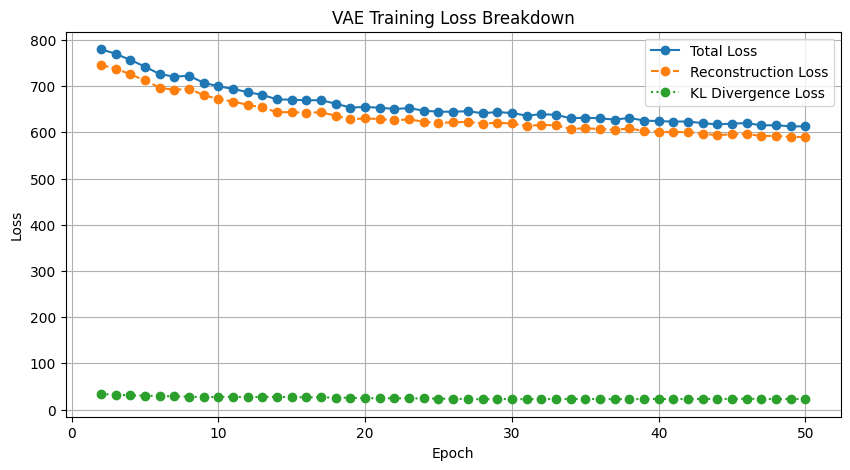

In [9]:
# Select the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Parameters
image_shape = (64, 64)
epochs = 50
latent_dim = 64

# Model name
model_name = f"FC-VAE_{image_shape[0]}x{image_shape[1]}_{latent_dim}L_{epochs}e.pth"

# Define the model
vae_model = FullyConnectedVAE(latent_dim=latent_dim)
#vae_model = load_trained_vae(model_name, latent_dim=latent_dim)

# Train the model
train_losses = train_vae(vae_model, train_loader, num_epochs=epochs, device=device, save_path=model_name)


---


In [10]:
# [Optional] Load VAE model
#vae_model = load_trained_vae("FC-VAE_colab_64x64_64L_50e.pth", latent_dim=64)

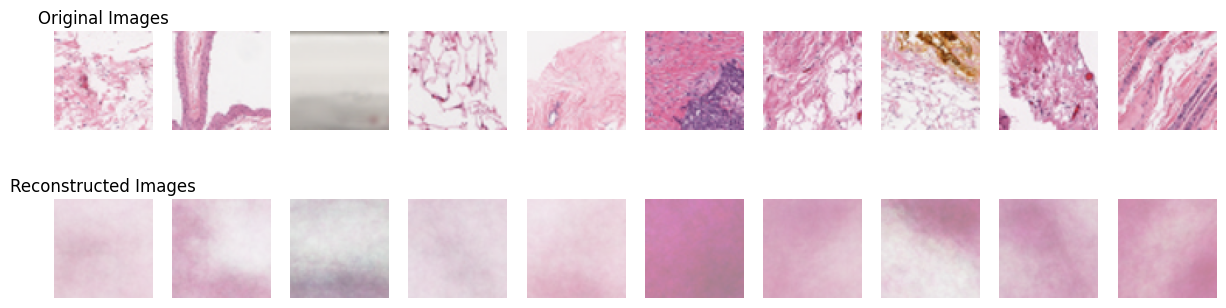

In [11]:
# Visualize reconstruction on training subset
visualize_reconstruction(vae_model, train_loader, 'training')

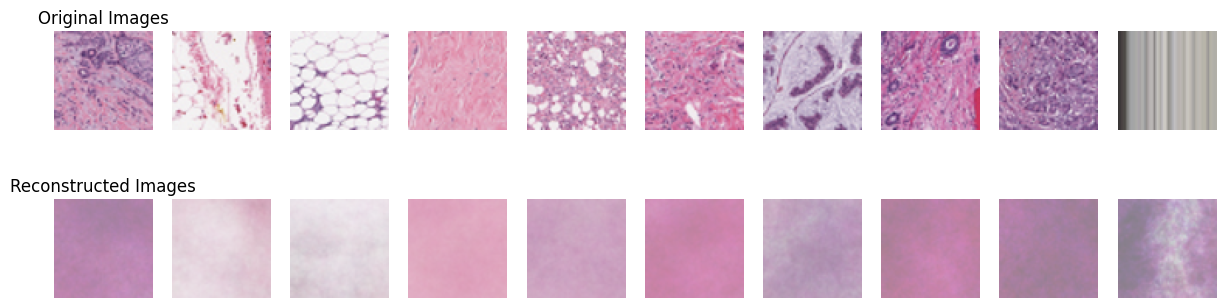

In [12]:
# Visualize reconstruction on validation subset
visualize_reconstruction(vae_model, val_loader, 'validation')

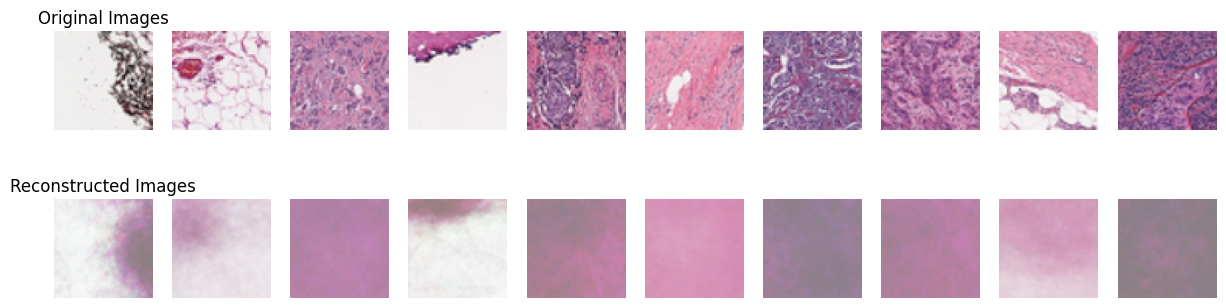

In [13]:
# Visualize reconstruction on testing subset
visualize_reconstruction(vae_model, test_loader, 'testing')

In [14]:
# Evaluate model performance on training subset
# evaluate_vae(vae_model, train_loader)

# Evaluate model performance on validation subset
# evaluate_vae(vae_model, val_loader)

# Evaluate model performance on testing subset
evaluate_vae(vae_model, test_loader)

Average Reconstruction Loss: 593.2462


593.246207750967



---

